In [18]:
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
BASE_DIR = Path().resolve().parent
BASE_DIR

PosixPath('/home/sadegh/python_projects/teesside/nencki_institute')

In [3]:
CSV_DIR = BASE_DIR / "data/features_final"
CSV_DIR

PosixPath('/home/sadegh/python_projects/teesside/nencki_institute/data/features_final')

In [4]:
dfs = {}

for csv_file in CSV_DIR.glob('*.csv'):
    df_name = csv_file.stem
    dfs[df_name] = pd.read_csv(csv_file)

In [20]:
markers = {
    "CD68": "CD68: Mean",
    "TMEM119": "TMEM119: Mean",
    "CD45": "CD45: Mean",
    "GPNMB": "GPNMB: Mean"
}

exclude_ids = {"2506", "2503", "4152", "4155", "4156", "17827"}

results = []

for file_name, df in dfs.items():

    patient_id = file_name.split(".")[0]

    # ---- Required for Problem 1 only ----
    required_p1 = ["CD68", "TMEM119", "CD45"]

    if not all(markers[m] in df.columns for m in required_p1):
        print(f"Skipping {patient_id}: missing required markers for Problem 1")
        continue

    # ---- Thresholds ----
    thresholds = {
        marker: df[markers[marker]].mean()
        for marker in required_p1
    }

    CD68_pos = df[markers["CD68"]] > thresholds["CD68"]
    TMEM119_pos = df[markers["TMEM119"]] > thresholds["TMEM119"]
    CD45_pos = df[markers["CD45"]] > thresholds["CD45"]

    # ---- Problem 1 ----
    triple_pos = CD68_pos & TMEM119_pos & CD45_pos
    tmem_neg = CD68_pos & (~TMEM119_pos) & CD45_pos

    total_area = len(df)

    triple_density = triple_pos.sum() / total_area
    tmem_neg_density = tmem_neg.sum() / total_area

    row = {
        "Biopsy": patient_id,
        "TMEM119pos_count": triple_pos.sum(),
        "TMEM119neg_count": tmem_neg.sum()
    }

    # ---- Problem 2 (only if GPNMB exists) ----
    if (
        markers["GPNMB"] in df.columns
        and patient_id not in exclude_ids
        and CD45_pos.sum() > 0
    ):

        thresholds["GPNMB"] = df[markers["GPNMB"]].mean()
        GPNMB_pos = df[markers["GPNMB"]] > thresholds["GPNMB"]

        GPNMB_pos_MG = (GPNMB_pos & CD68_pos & TMEM119_pos & CD45_pos).sum()
        GPNMB_neg_MG = ((~GPNMB_pos) & CD68_pos & TMEM119_pos & CD45_pos).sum()
        GPNMB_pos_Mphi = (GPNMB_pos & CD68_pos & (~TMEM119_pos) & CD45_pos).sum()
        GPNMB_neg_Mphi = ((~GPNMB_pos) & CD68_pos & (~TMEM119_pos) & CD45_pos).sum()

        total_CD45 = CD45_pos.sum()

        row.update({
            "% GPNMB+ MG": 100 * GPNMB_pos_MG / total_CD45,
            "% GPNMB- MG": 100 * GPNMB_neg_MG / total_CD45,
            "% GPNMB+ MΦ": 100 * GPNMB_pos_Mphi / total_CD45,
            "% GPNMB- MΦ": 100 * GPNMB_neg_Mphi / total_CD45
        })

    results.append(row)

final_results = pd.DataFrame(results)
final_results

,Biopsy,TMEM119pos_count,TMEM119neg_count,% GPNMB+ MG,% GPNMB- MG,% GPNMB+ MΦ,% GPNMB- MΦ
0,biopsy_926_upper,25,29,15.238095,8.571429,22.857143,4.761905
1,biopsy_5113_bottom,1967,1341,18.395744,21.853898,8.696542,18.743605
2,biopsy_3149_upper,646,2619,5.664133,6.026059,21.588853,25.805284
3,biopsy_2087_upper,102,7,14.655172,29.310345,2.155172,0.862069
4,biopsy_5731_bottom,313,105,5.323741,39.712230,10.791367,4.316547
5,biopsy_2503_upper,44,59,NaN,NaN,NaN,NaN
6,biopsy_4152_upper,83,43,NaN,NaN,NaN,NaN
7,biopsy_4891_upper,33,1,54.901961,9.803922,0.000000,1.960784
8,biopsy_4155_bottom,649,610,NaN,NaN,NaN,NaN
9,biopsy_1686_bottom,119,58,23.300971,15.210356,5.177994,13.592233


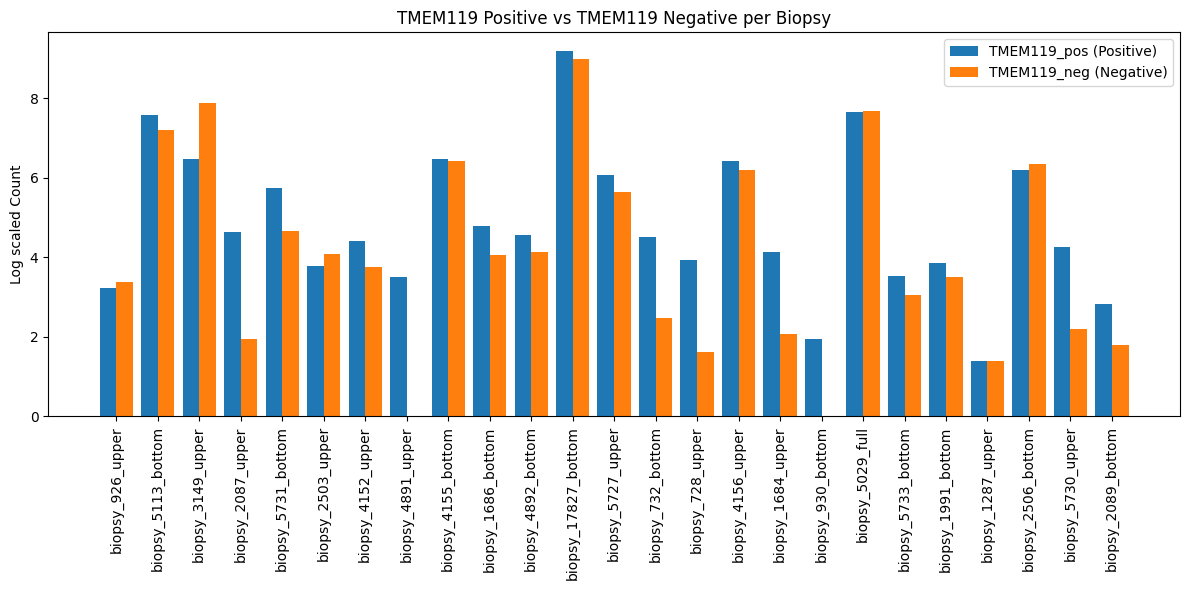

In [25]:
x = np.arange(len(final_results))
width = 0.4

plt.figure(figsize=(12,6))

plt.bar(x - width/2, np.log(final_results["TMEM119pos_count"]), width, label="TMEM119_pos (Positive)")
plt.bar(x + width/2, np.log(final_results["TMEM119neg_count"]), width, label="TMEM119_neg (Negative)")

plt.xticks(x, final_results["Biopsy"], rotation=90)
plt.ylabel("Log scaled Count")
plt.title("TMEM119 Positive vs TMEM119 Negative per Biopsy")
plt.legend()

plt.tight_layout()
plt.show()


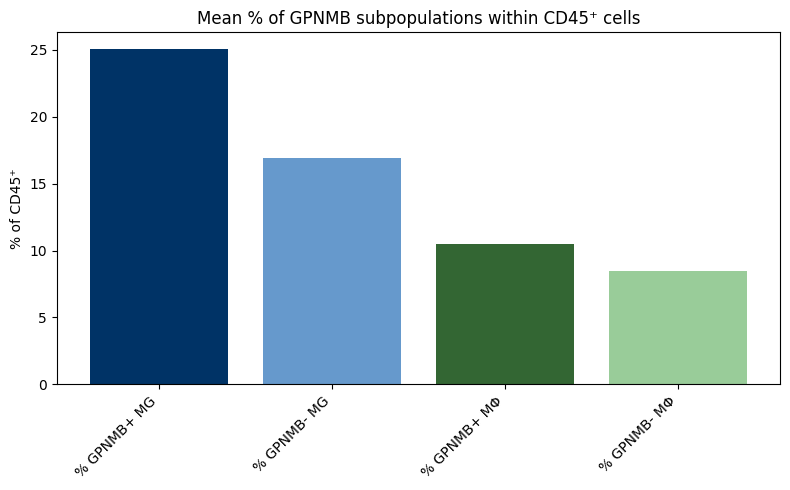

In [7]:
cols = ["% GPNMB+ MG", "% GPNMB- MG", "% GPNMB+ MΦ", "% GPNMB- MΦ"]

means = final_results[cols].mean()

colors = ['#003366', '#6699cc', '#336633', '#99cc99']

plt.figure(figsize=(8,5))
bars = plt.bar(means.index, means.values, color=colors)

plt.ylabel("% of CD45⁺")
plt.xticks(rotation=45, ha='right')
plt.title("Mean % of GPNMB subpopulations within CD45⁺ cells")
plt.tight_layout()

plt.show()

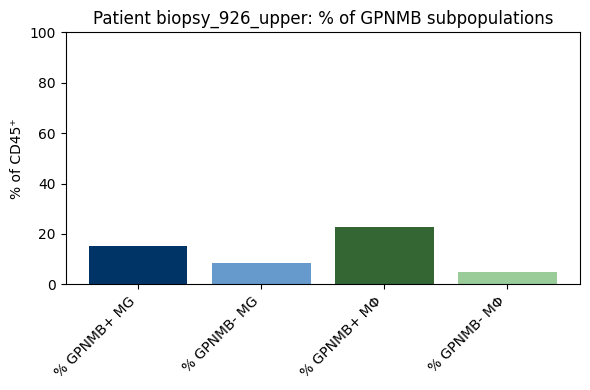

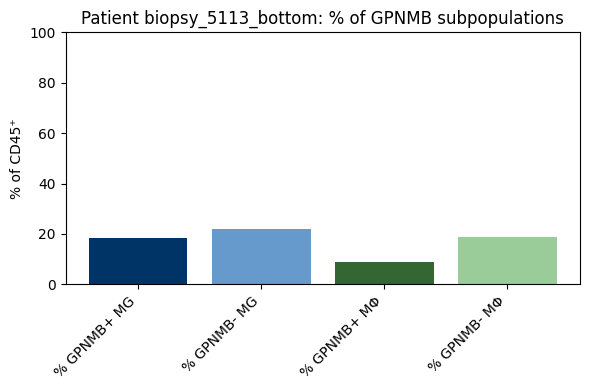

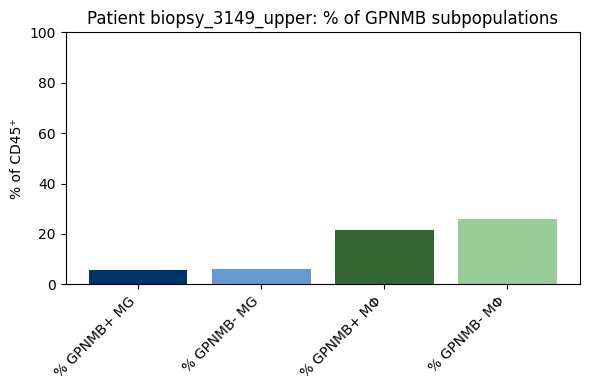

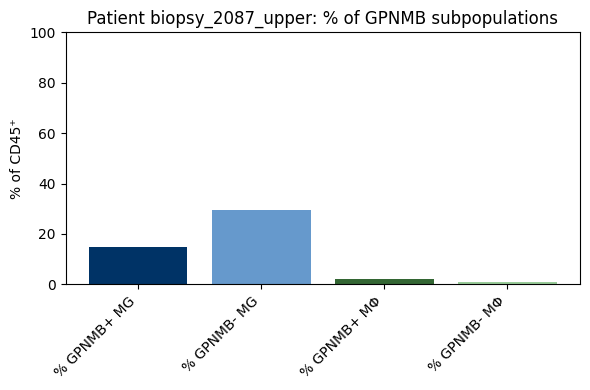

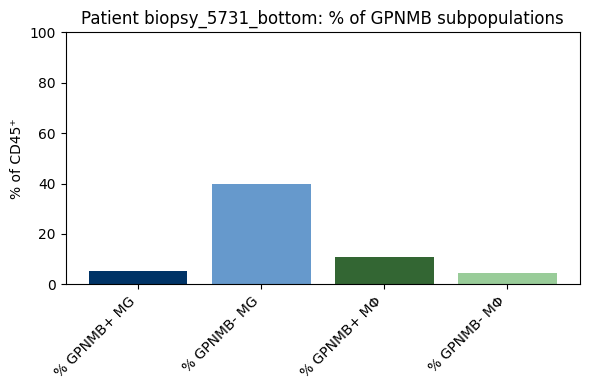

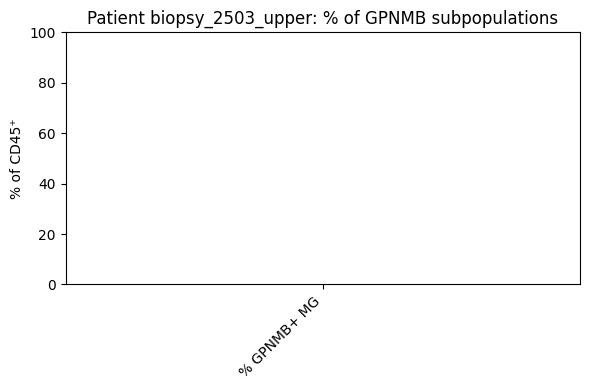

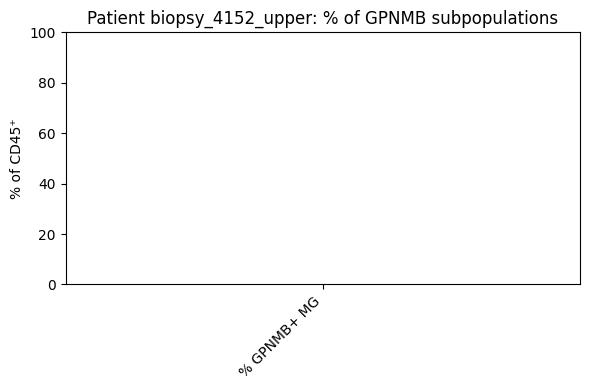

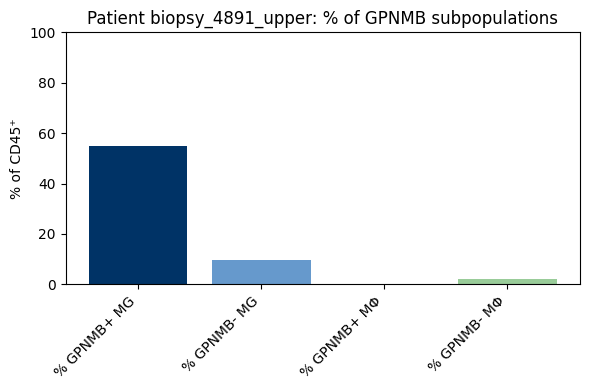

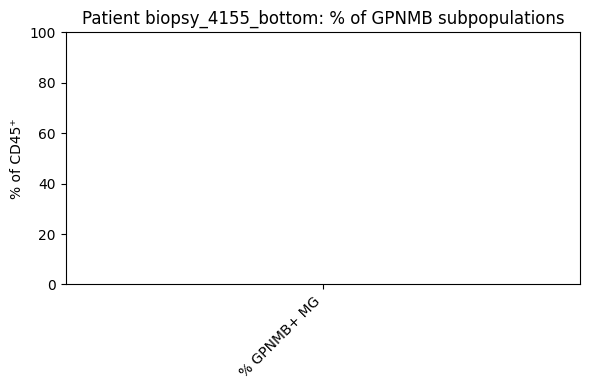

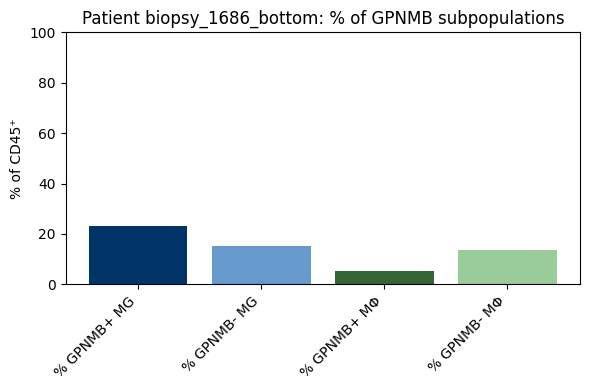

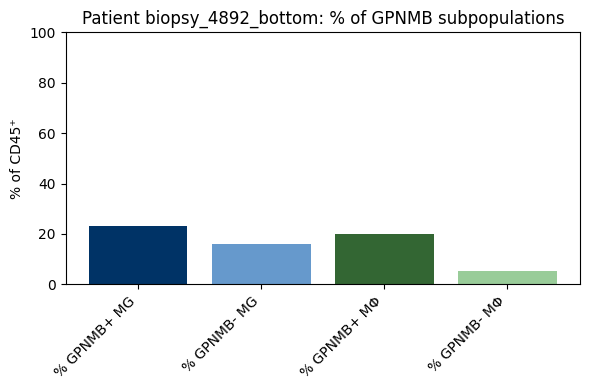

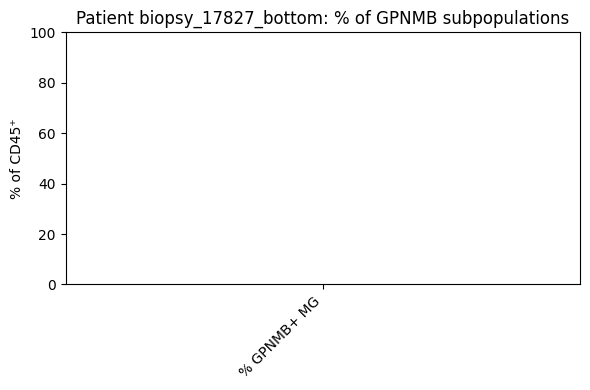

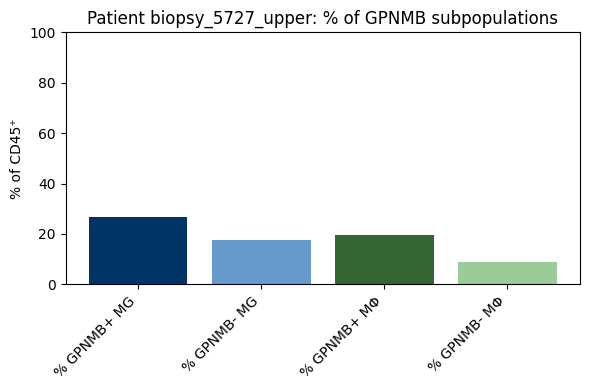

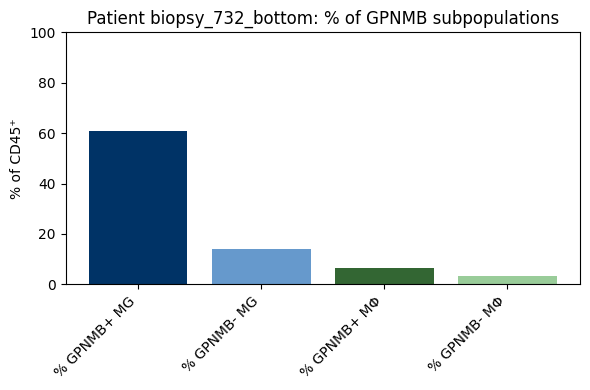

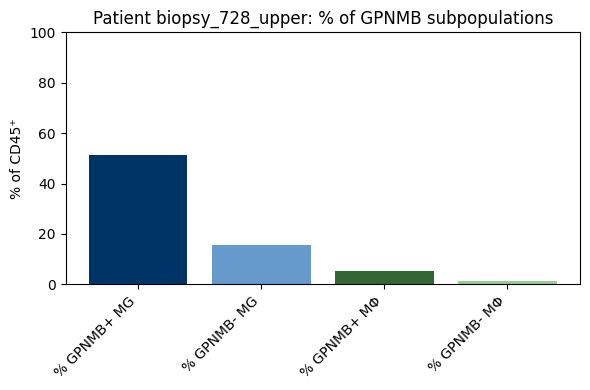

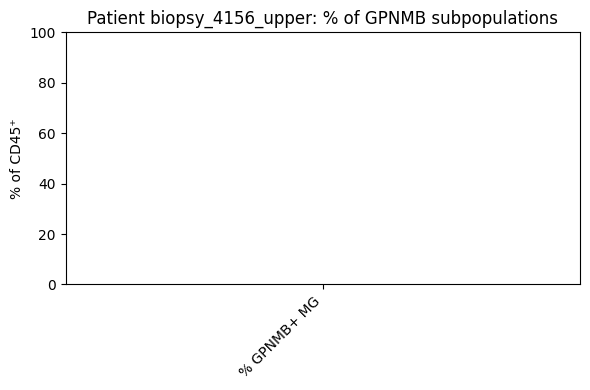

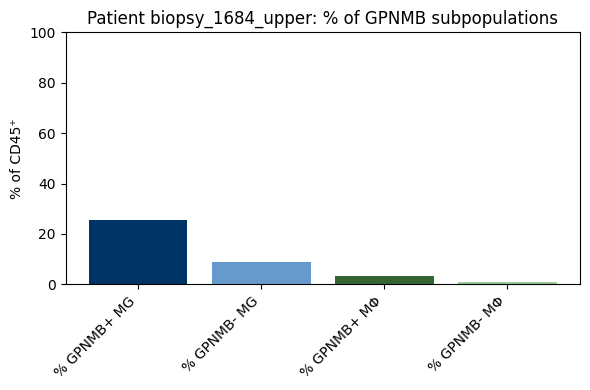

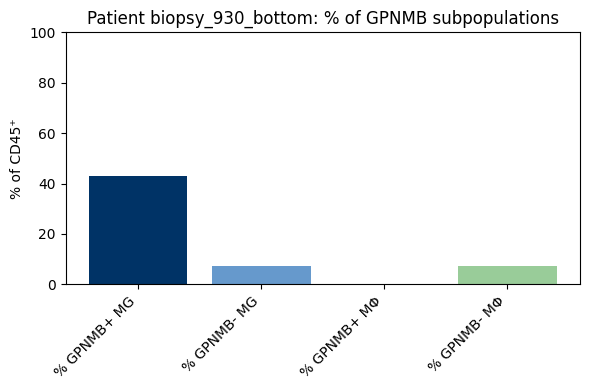

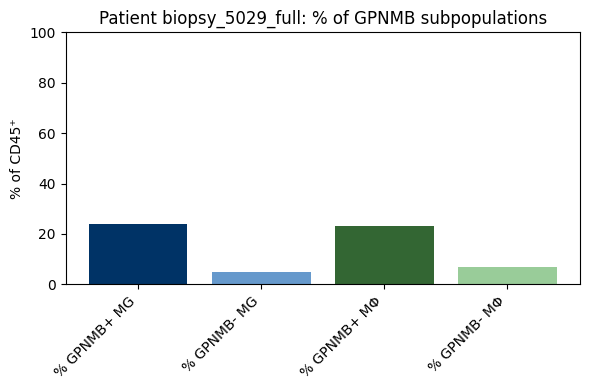

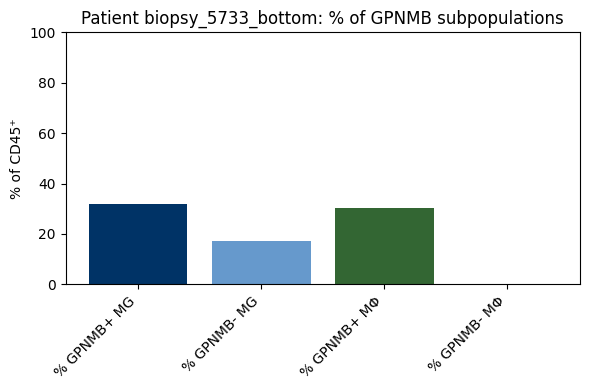

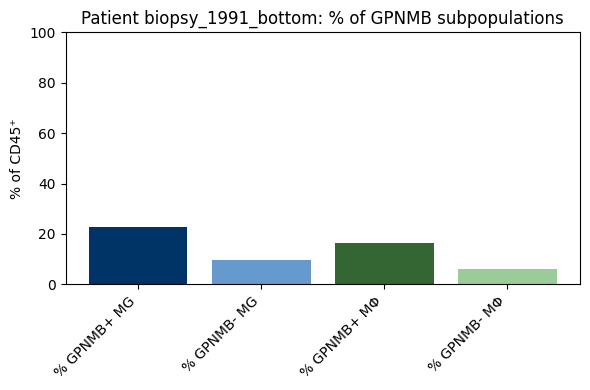

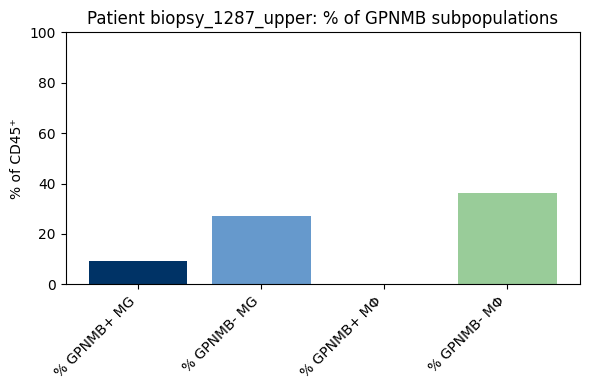

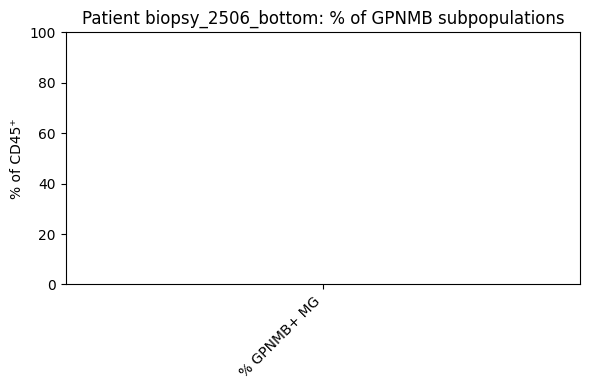

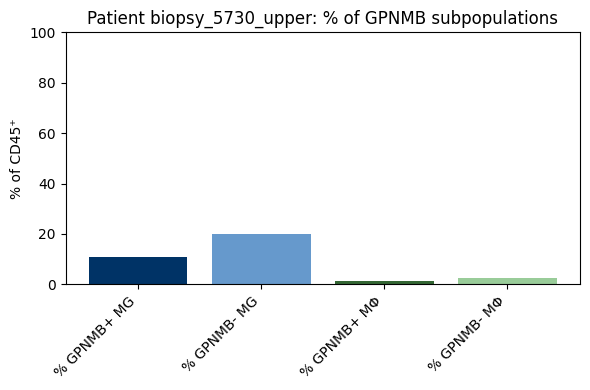

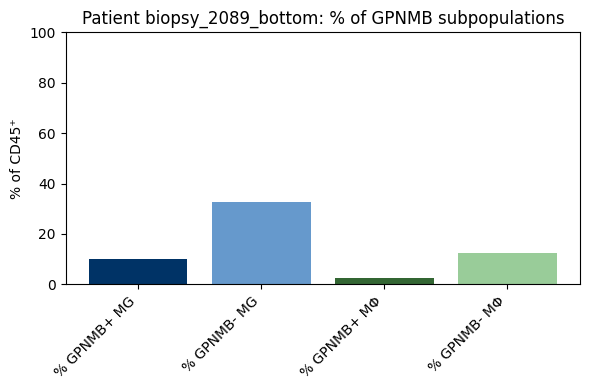

In [8]:
cols = ["% GPNMB+ MG", "% GPNMB- MG", "% GPNMB+ MΦ", "% GPNMB- MΦ"]
colors = ['#003366', '#6699cc', '#336633', '#99cc99']

for idx, row in final_results.iterrows():
    patient_id = row["Patient"]
    values = row[cols].values

    plt.figure(figsize=(6,4))
    plt.bar(cols, values, color=colors)
    plt.title(f"Patient {patient_id}: % of GPNMB subpopulations")
    plt.ylabel("% of CD45⁺")
    plt.ylim(0, 100)
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()
